In [2]:
!pip install kagglehub

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [3]:
import kagglehub
import shutil, os

dataset_path = kagglehub.dataset_download("pengcw1/market-1501")
target_dir = os.path.join(os.getcwd(), "data")
shutil.copytree(dataset_path, target_dir, dirs_exist_ok=True)

'c:\\Users\\jokub\\Desktop\\Tiriamasis projektas\\Tiriamasis\\data'

Use cuda


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"


Using device: cuda


Dataset reading and display

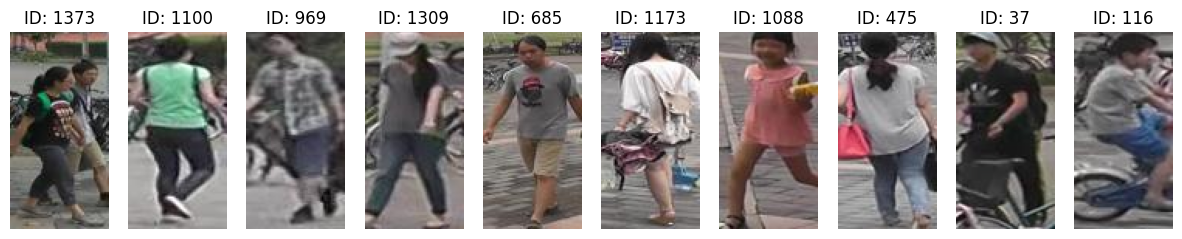

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torch
from torchvision.transforms import RandomErasing, ColorJitter
import os
import matplotlib.pyplot as plt
import numpy as np
path = "c:\\Users\\jokub\\Desktop\\Tiriamasis projektas\\Tiriamasis\\data\\Market-1501-v15.09.15"

class Market1501Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.img_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith('.jpg')]
        
        self.labels = []
        for img in os.listdir(data_dir):
            if img.endswith('.jpg'):
                person_id = img.split('_')[0]
                self.labels.append(int(person_id) if person_id != '-1' else -1)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    
transform = transforms.Compose([
    transforms.Resize((128, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = Market1501Dataset(os.path.join(path, "bounding_box_train"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = Market1501Dataset(os.path.join(path, "bounding_box_test"), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

query_dataset = Market1501Dataset(os.path.join(path, "query"), transform=transform)
query_loader = DataLoader(query_dataset, batch_size=32, shuffle=False)

#NUM_CLASSES = len(set(label for _, label in train_loader.dataset))    

def show_images(images, labels, num_images=10):
    images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    images = images.clamp(0, 1)

    indices = np.random.choice(images.shape[0], num_images, replace=False)
    selected_images = images[indices]
    selected_labels = labels[indices]

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(selected_images[i].permute(1, 2, 0).cpu().numpy())
        plt.title(f"ID: {selected_labels[i].item()}")
        plt.axis("off")
    plt.show()

images, labels = next(iter(train_loader))
show_images(images, labels, num_images=10)

Models classes

In [24]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
from sklearn.metrics.pairwise import cosine_similarity


class ReIDModel(nn.Module):
    def __init__(self, embedding_dim=512):
        super(ReIDModel, self).__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, embedding_dim)
        self.embedding_dim = embedding_dim

    def forward(self, x):
        x = self.backbone(x)
        x = F.normalize(x, p=2, dim=1)
        return x

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()
    
class ReIDModelClasses(nn.Module):
    def __init__(self, num_classes):
        super(ReIDModelClasses, self).__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 1501)

    def forward(self, x):
        return self.backbone(x)


def create_triplets(images, labels):
    triplets = []
    labels = labels.cpu().numpy()
    for i in range(len(images)):
        anchor, label = images[i], labels[i]
        positive_idx = np.where(labels == label)[0]
        negative_idx = np.where(labels != label)[0]
        if len(positive_idx) > 1 and len(negative_idx) > 0:
            positive = images[np.random.choice(positive_idx)]
            negative = images[np.random.choice(negative_idx)]
            triplets.append((anchor, positive, negative))
    return triplets


Training methods

In [25]:
def hard_triplet_mining(anchor_emb, positive_emb, negative_emb, margin):
    """Compute the hardest positives and negatives for triplet loss."""
    pos_dist = F.pairwise_distance(anchor_emb, positive_emb, p=2)
    neg_dist = F.pairwise_distance(anchor_emb, negative_emb, p=2)

    hard_positive = torch.max(pos_dist)
    hard_negative = torch.min(neg_dist)

    triplet_loss = torch.relu(hard_positive - hard_negative + margin)
    return triplet_loss

def train_model_triplet(train_loader, device, num_epochs=100, lr=0.0003, margin=1.0, patience=5):
    model = ReIDModel(embedding_dim=512)
    model = model.to(device)
    criterion = TripletLoss(margin=margin)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    best_loss = math.inf
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        num_triplets = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            triplets = create_triplets(images, labels)
            if len(triplets) == 0:
                continue

            for anchor, positive, negative in triplets:
                anchor, positive, negative = (
                    anchor.unsqueeze(0),
                    positive.unsqueeze(0),
                    negative.unsqueeze(0),
                )
                anchor_emb = model(anchor)
                positive_emb = model(positive)
                negative_emb = model(negative)

                loss = hard_triplet_mining(anchor_emb, positive_emb, negative_emb, margin)
                running_loss += loss.item()
                num_triplets += 1

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epoch_loss = running_loss / num_triplets if num_triplets > 0 else 0.0

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_triplet.pth")
        else:
            patience_counter += 1

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Best Loss: {best_loss:.4f}")

        # Check for early stopping
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

        scheduler.step()

    print("Training complete.")
    return model

def train_model_backbone(train_loader, device, num_epochs=10, lr=0.0003):
    model = ReIDModelClasses(num_classes=1501)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float("inf")

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), 'best_model_backbone.pth')

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    print("Training completed.")
    return model


Embed generation methods

In [26]:
def generate_embeddings_triplet(model, data_loader, device):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.to(device)
            emb = model(images)
            embeddings.append(emb.cpu())
            labels.append(lbls)
    return torch.cat(embeddings), torch.cat(labels)

def extract_features(model, dataloader, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images, lbls = images.to(device), lbls.to(device)
            outputs = model(images)  
            features.append(outputs.cpu())
            labels.append(lbls.cpu()) 
    return torch.cat(features), torch.cat(labels)

Evaluation methods

In [27]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_embeddings_triplet(query_embeddings, gallery_embeddings):
    similarity_matrix = cosine_similarity(query_embeddings, gallery_embeddings)
    return similarity_matrix

def batched_cosine_similarity(query_features, gallery_features, batch_size=128):
    num_queries = query_features.shape[0]
    num_gallery = gallery_features.shape[0]
    similarity_matrix = np.zeros((num_queries, num_gallery))

    for i in range(0, num_queries, batch_size):
        query_batch = query_features[i:i + batch_size]
        similarity_matrix[i:i + batch_size] = cosine_similarity(query_batch, gallery_features)

    return similarity_matrix

def evaluate(query_features, query_labels, gallery_features, gallery_labels):
    query_features = query_features.numpy()
    query_labels = query_labels.numpy()
    gallery_features = gallery_features.numpy()
    gallery_labels = gallery_labels.numpy()
    
    similarity_matrix = batched_cosine_similarity(query_features, gallery_features)
    
    # Sort the similarity matrix to find the top matches
    sorted_indices = np.argsort(-similarity_matrix, axis=1)
    
    # Compute Rank-1 accuracy
    rank1 = np.sum(gallery_labels[sorted_indices[:, 0]] == query_labels)
    rank1_accuracy = rank1 / len(query_labels)
    
    # Compute mAP
    average_precision = []
    
    for i in range(len(query_labels)):
        relevant = gallery_labels[sorted_indices[i]] == query_labels[i]
        
        if relevant.sum() == 0:  # Skip if no relevant items
            continue
        
        # Compute precision at each rank using vectorized operations
        cumulative_retrieved = np.cumsum(relevant)
        precision_at_k = cumulative_retrieved / (np.arange(1, len(sorted_indices[i]) + 1))
        
        # Only include precision values where relevant items were retrieved
        relevant_precision = precision_at_k[relevant]
        
        if relevant_precision.size > 0:
            average_precision.append(relevant_precision.mean())
    
    mAP = np.mean(average_precision) if average_precision else 0
    
    return rank1_accuracy, mAP

In [38]:
model = train_model_triplet(train_loader, device, num_epochs=10)

Epoch [1/10], Loss: 0.4690, Best Loss: 0.4690
Epoch [2/10], Loss: 0.4818, Best Loss: 0.4690
Epoch [3/10], Loss: 0.5852, Best Loss: 0.4690
Epoch [4/10], Loss: 0.4839, Best Loss: 0.4690
Epoch [5/10], Loss: 0.5300, Best Loss: 0.4690
Epoch [6/10], Loss: 0.5126, Best Loss: 0.4690
Early stopping triggered!
Training complete.


In [29]:
model2 = train_model_backbone(train_loader, device, num_epochs=10)

Epoch 1/10, Loss: 3.9177
Epoch 2/10, Loss: 0.4946
Epoch 3/10, Loss: 0.0952
Epoch 4/10, Loss: 0.0272
Epoch 5/10, Loss: 0.0280
Epoch 6/10, Loss: 0.0632
Epoch 7/10, Loss: 0.0852
Epoch 8/10, Loss: 0.0674
Epoch 9/10, Loss: 0.0362
Epoch 10/10, Loss: 0.0231
Training completed.


In [39]:
query_embeddings, query_labels = generate_embeddings_triplet(model, query_loader, device)
gallery_embeddings, gallery_labels = generate_embeddings_triplet(model, test_loader, device)

In [40]:
similarity_matrix = evaluate_embeddings_triplet(query_embeddings, gallery_embeddings)
print(f"Similarity Matrix Shape: {similarity_matrix.shape}")

Similarity Matrix Shape: (3368, 19732)


In [35]:
gallery_features, gallery_labels = extract_features(model2, test_loader, device)
query_features, query_labels = extract_features(model2, query_loader, device)

In [36]:
rank1, mAP = evaluate(query_features, query_labels, gallery_features, gallery_labels)
print(f"Rank-1 Accuracy: {rank1:.4f}, mAP: {mAP:.4f}")

Rank-1 Accuracy: 0.9587, mAP: 0.4638


In [37]:
for i in range(len(query_labels)):
    relevant = (gallery_labels == query_labels[i]).sum()
    print(f"Query {i}: {relevant} relevant matches")


Query 0: 59 relevant matches
Query 1: 59 relevant matches
Query 2: 59 relevant matches
Query 3: 59 relevant matches
Query 4: 59 relevant matches
Query 5: 59 relevant matches
Query 6: 10 relevant matches
Query 7: 10 relevant matches
Query 8: 10 relevant matches
Query 9: 10 relevant matches
Query 10: 10 relevant matches
Query 11: 22 relevant matches
Query 12: 22 relevant matches
Query 13: 22 relevant matches
Query 14: 22 relevant matches
Query 15: 22 relevant matches
Query 16: 42 relevant matches
Query 17: 42 relevant matches
Query 18: 42 relevant matches
Query 19: 42 relevant matches
Query 20: 42 relevant matches
Query 21: 42 relevant matches
Query 22: 9 relevant matches
Query 23: 9 relevant matches
Query 24: 9 relevant matches
Query 25: 9 relevant matches
Query 26: 9 relevant matches
Query 27: 6 relevant matches
Query 28: 6 relevant matches
Query 29: 6 relevant matches
Query 30: 8 relevant matches
Query 31: 8 relevant matches
Query 32: 8 relevant matches
Query 33: 5 relevant matches
Qu